In [1]:
import warnings
import vectorbt as vbt
warnings.filterwarnings('ignore')
%matplotlib inline

### Indicador MACD (Moving Average Convergence Divergence)

Analisa a **convergência** e **divergência** entre duas médias móveis para tentar identificar **tendências** de preço. É composto pela linha MACD, uma linha de sinal e histograma. Podemos gerar sinais de compras e vendas a partir do cruzamento das linhas.

O cruzamentos da linha MACD com a linha sinal podem indicar uma tendência de alta, já se a linha de sinal estiver acima da linha do MACD, pode ser um indicador de tendência de baixa.

In [2]:
# Dados da empresa Vale
dados = vbt.YFData.download('VALE3.SA').get()

In [3]:
dados.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00+00:00,1.795994,1.817803,1.795994,1.795994,585600,0.0,0.0
2000-01-04 00:00:00+00:00,1.778890,1.782739,1.753233,1.753233,782400,0.0,0.0
2000-01-05 00:00:00+00:00,1.731853,1.753233,1.731853,1.753233,1876800,0.0,0.0


Gráfico OHLC (Candlestick), isto é, Open (**O**), High (**H**), Low (**L**) e Close (**C**) 

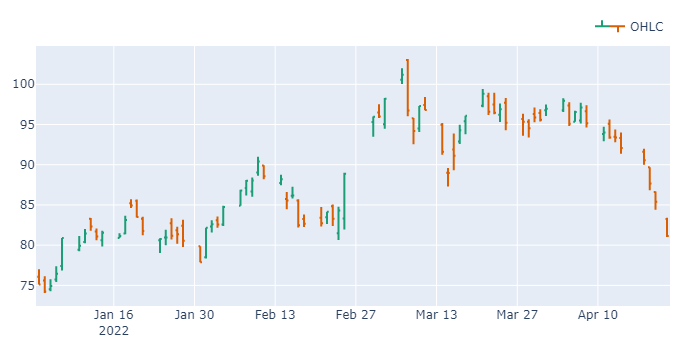

In [5]:
dados['2022'].vbt.ohlcv.plot(show_volume=False).show_png()

***
### MACD


- Linha MACD: Diferença entre uma média móvel curta e uma média móvel longa. 
- Linha de sinal: média móvel formada pela própria linha do MACD. 
- Histograma MACD: representação visual da diferença do valor da linha MACD com a linha de sinal

In [6]:
fechamento = dados['Close'] # Preço de fechamento

**Obtendo as linhas do MACD**

    Média curta: 12
    Média longa: 26
    Média linha de sinal: 9

In [7]:
macd = vbt.MACD.run(fechamento, fast_window=12, slow_window=26, signal_window=9)

Podemos chamar a função plot do objeto macd para visualizar as linhas e histograma

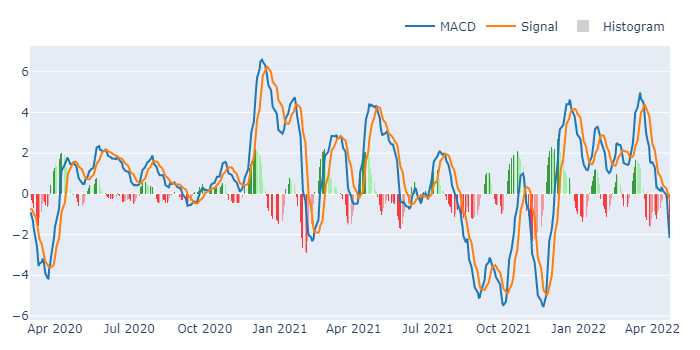

In [10]:
macd['2020-03':].plot().show_png()

É possível também acessar diretamente os valores das linhas criadas na execução do MACD

In [11]:
linha_macd = macd.macd # Linha MACD
linha_macd.tail(3)

Date
2022-04-19 00:00:00+00:00   -0.351730
2022-04-20 00:00:00+00:00   -1.076602
2022-04-22 00:00:00+00:00   -2.175448
Name: (12, 26, 9, Close), dtype: float64

In [12]:
linha_sinal = macd.signal # Linha de sinal
linha_sinal.tail(3)

Date
2022-04-19 00:00:00+00:00    0.144521
2022-04-20 00:00:00+00:00   -0.009267
2022-04-22 00:00:00+00:00   -0.285059
Name: (12, 26, 9, Close), dtype: float64

In [13]:
histograma = macd.hist # Histograma MACD
histograma.tail(3)

Date
2022-04-19 00:00:00+00:00   -0.496252
2022-04-20 00:00:00+00:00   -1.067335
2022-04-22 00:00:00+00:00   -1.890389
Name: (12, 26, 9, Close), dtype: float64

In [14]:
# Linha de sinal maior que a linha MACD?
linha_sinal > linha_macd

Date
2000-01-03 00:00:00+00:00    False
2000-01-04 00:00:00+00:00    False
2000-01-05 00:00:00+00:00    False
2000-01-06 00:00:00+00:00    False
2000-01-07 00:00:00+00:00    False
                             ...  
2022-04-14 00:00:00+00:00     True
2022-04-18 00:00:00+00:00     True
2022-04-19 00:00:00+00:00     True
2022-04-20 00:00:00+00:00     True
2022-04-22 00:00:00+00:00     True
Name: (12, 26, 9, Close), Length: 5604, dtype: bool

***

### Estratégia

* **COMPRAR** (= +1) quando MACD está acima de zero E da linha de sinal
* **VENDER** (= -1) quando o MACD está abaixo de zero OU da linha de sinal

Fonte: https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/macd#:~:text=When%20the%20MACD%20line%20crosses,line%20the%20stronger%20the%20signal.

In [15]:
compra = macd.macd_above(0) & macd.macd_above(macd.signal)
venda = macd.macd_below(0) | macd.macd_below(macd.signal)

Vamos agora **executar o backtest** passando o histórico de preços do ativo e os pontos de entrada (compra) e saída (venda). 

Defini frequência dos dados como diária (freq='d').

In [16]:
pf = vbt.Portfolio.from_signals(fechamento, compra, venda, freq='d')

Como resultado temos retorno total de 90.01 , isso quer dizer que ao final somado ao investimento inicial 100.00 teríamos 190.01

In [17]:
pf.stats()[['Start', 'End', 'Period', 'Start Value', 'End Value', 'Total Return [%]']]

Start               2000-01-03 00:00:00+00:00
End                 2022-04-22 00:00:00+00:00
Period                     5604 days 00:00:00
Start Value                             100.0
End Value                          190.015014
Total Return [%]                    90.015014
dtype: object

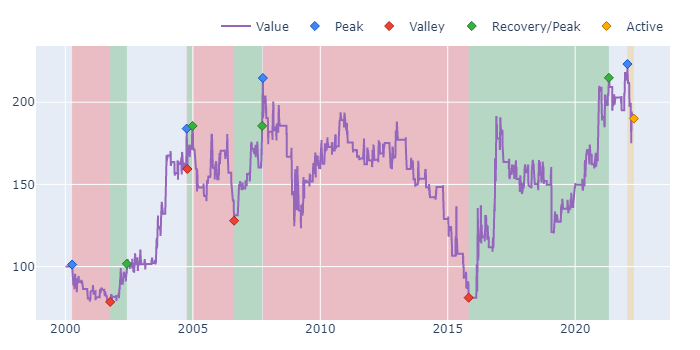

In [18]:
pf.plot_drawdowns().show_png()

Retorno acumulado

<AxesSubplot:xlabel='Date'>

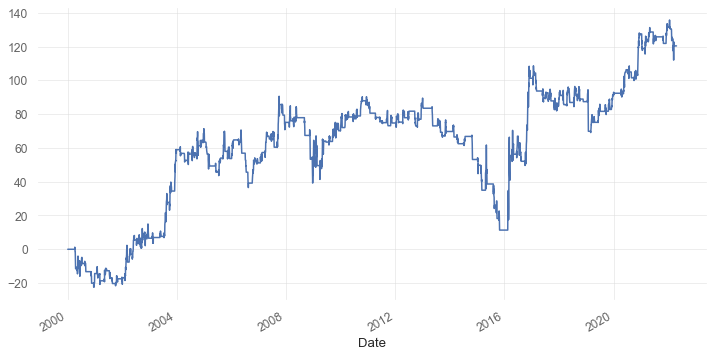

In [19]:
(pf.returns().cumsum() * 100).plot(figsize=(12,6))